# Introduction

The notebook is inspired by [*A Killer Adversary for Quicksort*](https://www.cs.dartmouth.edu/~doug/mdmspe.pdf), which introduces a simple yet very efficient algorithm for compare function to make almost any pure quicksort implementation under their worst case $\mathcal O (N^2)$.

The notebook can be separated into several parts:
1. A simple quicksort implementation, which works as $\mathcal O (N^2)$ at sorted data, to warm up.
2. Implement the widely used median of 3 quicksort which performs well at sorted data. The algorithm still have weaknesses, so an artificial killer for the implementation is devised.
3. Introduce the automatic quicksort killer which can beat not only median of 3 pivot but also median of random 3 pivot.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Build a naive quicksort

In [2]:
def partition(array, l, r):
    pivot = array[l]
    while l < r:
        while pivot < array[r]:
            r -= 1
        array[l], array[r] = array[r], array[l]
        while array[l] < pivot:
            l += 1
        array[l], array[r] = array[r], array[l]
    array[l] = pivot
    return l

In [3]:
def quicksort_rec(l, start=None, end=None):
    if start is None:
        start = 0
    if end is None:
        end = len(l) - 1
    if end - start < 1:
        return l
    p = partition(l, start, end)
    quicksort_rec(l, start, p)
    quicksort_rec(l, p+1, end)
    return l

In [4]:
sz = 10000
m = np.arange(sz)
np.random.shuffle(m)
np.allclose(quicksort_rec(m.copy()), np.arange(sz))

True

# Build a iterative quicksort

In [5]:
def quicksort_iter(array):
    stack = [(0, len(array) - 1)]
    while stack:
        l, r = stack[-1]
        if r - l < 1:
            stack.pop()
            continue
        pivot = array[l]
        while l < r:
            while pivot < array[r]:
                r -= 1
            array[l], array[r] = array[r], array[l]
            while array[l] < pivot:
                l += 1
            array[l], array[r] = array[r], array[l]
        array[l] = pivot
        ll, rr = stack.pop()
        stack.append((ll, l-1))
        stack.append((l+1, rr))
    return array

In [6]:
sz = 10000
m = np.arange(sz)
np.random.shuffle(m)
np.allclose(quicksort_iter(m.copy()), np.arange(sz))

True

# Counter benchmark of the sorter

In [7]:
# a counter is added for each comparison
def quicksort(array):
    stack = [(0, len(array) - 1)]
    counter = 0
    while stack:
        l, r = stack[-1]
        if r - l < 1:
            stack.pop()
            continue
        pivot = array[l]
        while l < r:
            counter += 1
            while pivot < array[r]:
                r -= 1
                counter += 1
            array[l], array[r] = array[r], array[l]
            counter += 1
            while array[l] < pivot:
                l += 1
                counter += 1
            array[l], array[r] = array[r], array[l]
        array[l] = pivot
        ll, rr = stack.pop()
        stack.append((ll, l-1))
        stack.append((l+1, rr))
    return array, counter

### random case. $\mathcal O (N\textrm{log}N)$

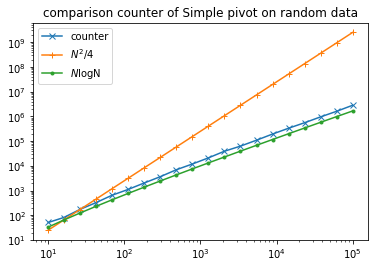

In [8]:
szs = np.logspace(1, 5, 20, dtype=np.int64)
counters = []
for sz in szs:
    m = np.arange(sz)
    np.random.shuffle(m)
    array, counter = quicksort(m.copy())
    assert np.allclose(array, np.arange(sz))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/4, label=r'$N^2$/4', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of Simple pivot on random data')
plt.show()

### worst case. $\mathcal O (N^2)$

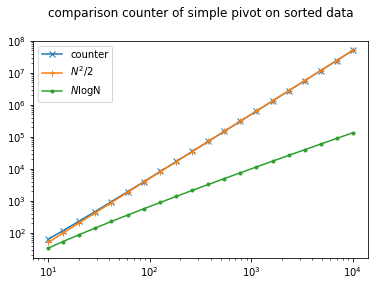

In [9]:
# arrays are smaller to reduce time cost
szs = np.logspace(1, 4, 20, dtype=np.int64)
counters = []
for sz in szs:
    m = np.arange(sz)
    array, counter = quicksort(m.copy())
    assert np.allclose(array, np.arange(sz))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/2, label=r'$N^2$/2', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of simple pivot on sorted data', y=1.08)
plt.show()

# Median of 3 solution to the worst case

In [10]:
def quicksort_m3(array):
    stack = [(0, len(array) - 1)]
    counter = 0
    while stack:
        l, r = stack[-1]
        if r - l < 1:
            stack.pop()
            continue
        m = (l + r) // 2
        # bubble sort
        if array[m] < array[l]:
            array[l], array[m] = array[m], array[l]
        if array[r] < array[m]:
            array[m], array[r] = array[r], array[m]
        if array[m] < array[l]:
            array[l], array[m] = array[m], array[l]  
        counter += 3
        array[l], array[m] = array[m], array[l]
        pivot = array[l]
        while l < r:
            counter += 1
            while pivot < array[r]:
                counter += 1
                r -= 1
            array[l], array[r] = array[r], array[l]
            counter += 1
            while array[l] < pivot:
                counter += 1
                l += 1
            array[l], array[r] = array[r], array[l]
        array[l] = pivot
        ll, rr = stack.pop()
        stack.append((ll, l-1))
        stack.append((l+1, rr))
    return array, counter

### random case. $\mathcal O (N\textrm{log}N)$

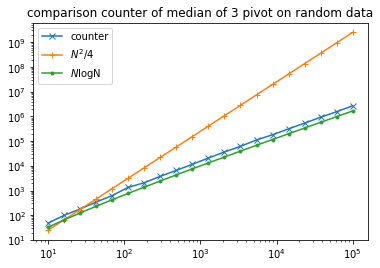

In [11]:
szs = np.logspace(1, 5, 20, dtype=np.int64)
counters = []
for sz in szs:
    m = np.arange(sz)
    np.random.shuffle(m)
    array, counter = quicksort_m3(m.copy())
    assert np.allclose(array, np.arange(sz))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/4, label=r'$N^2$/4', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of median of 3 pivot on random data')
plt.show()

### "worst" case. $\mathcal O (N\textrm{log}N)$

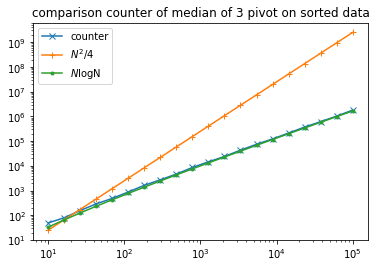

In [12]:
szs = np.logspace(1, 5, 20, dtype=np.int64)
counters = []
for sz in szs:
    m = np.arange(sz)
    array, counter = quicksort_m3(m.copy())
    assert np.allclose(array, np.arange(sz))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/4, label=r'$N^2$/4', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of median of 3 pivot on sorted data')
plt.show()

# Artificial median of 3 killer. $\mathcal O (N^2)$

In [13]:
def artificial_killer(sz):
    m = [1, 0]
    while len(m) < sz:
        m = [len(m)] + m[1:] + [m[0], len(m)+1] 
    return m

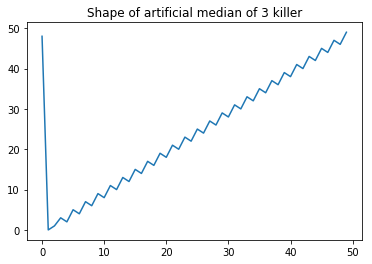

In [14]:
plt.plot(artificial_killer(50))
plt.title('Shape of artificial median of 3 killer')
plt.show()

In [15]:
sz = 10000
m = artificial_killer(sz)

In [16]:
# the 2nd largest, any number, the 1st largest
# thus the partition will result in two extrememly unbanlanced sub-arrays
m[0], m[(0+sz-1)//2], m[sz-1]

(9998, 4999, 9999)

In [17]:
# the 3rd largest, the 4th largest, 
# in the larger sub-array the pattern persists
m[sz-3], m[sz-2]

(9997, 9996)

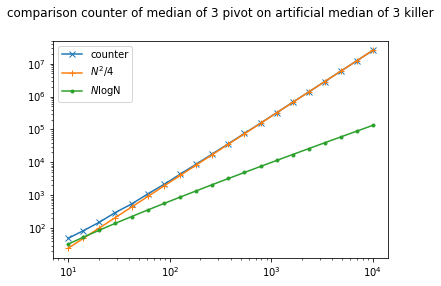

In [18]:
# arrays are smaller to reduce time cost
szs = np.logspace(1, 4, 20, dtype=np.int)
counters = []
for sz in szs:
    m = artificial_killer(sz)
    array, counter = quicksort_m3(m.copy())
    assert np.allclose(array, np.arange(len(m)))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/4, label=r'$N^2/4$', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of median of 3 pivot on artificial median of 3 killer', y=1.08)
plt.show()

# Automatic quicksort killer

### use a group of benign int for sorting. $\mathcal O (N\textrm{log}N)$

In [19]:
class BenignInt:
    def __init__(self, f):
        self.f = f
        
    def __lt__(self, other):
        return self.f < other.f

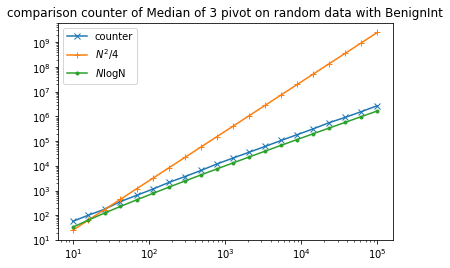

In [20]:
szs = np.logspace(1, 5, 20, dtype=np.int64)
counters = []
for sz in szs:
    m = np.arange(sz)
    np.random.shuffle(m)
    array, counter = quicksort_m3(list(map(BenignInt, m)))
    np.allclose([f.f for f in array], np.arange(sz))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/4, label=r'$N^2$/4', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of Median of 3 pivot on random data with BenignInt')
plt.show()

### use a group of killer int for sorting. $\mathcal O (N^2)$

In [21]:
class KillerInt:

    nsolid = 0
    
    @classmethod
    def init(cls, sz):
        cls.nsolid = sz-1
    
    def __init__(self):
        self.f = 0
        self.candidate = False
        
    def freeze(self):
        self.f = self.__class__.nsolid
        self.__class__.nsolid -= 1
        
    def __lt__(self, other):
        if self.f is 0 and other.f is 0:
            if self.candidate:
                self.freeze()
            else:
                other.freeze()
        if self.f is 0 and other.f is not 0:
            self.candidate = True
            return True
        elif self.f is not 0 and other.f is 0:
            other.candidate = True
            return False
        else:
            return self.f < other.f

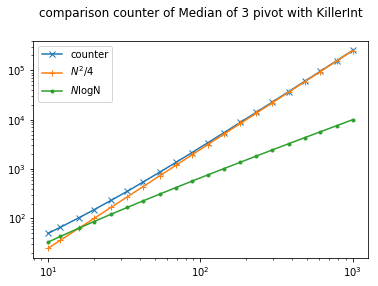

In [22]:
# arrays are smaller to reduce time cost
szs = np.logspace(1, 3, 20, dtype=np.int64)
counters = []
for sz in szs:
    KillerInt.init(sz)
    array, counter = quicksort_m3([KillerInt() for _ in range(sz)])
    array = [f.f for f in array]
    assert np.allclose(array, np.arange(sz))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/4, label=r'$N^2$/4', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of Median of 3 pivot with KillerInt', y=1.08)
plt.show()

### Median of random 3 is useless against automatic quicksork killer. $\mathcal O (N^2)$

In [23]:
def quicksort_r3(array):
    stack = [(0, len(array) - 1)]
    counter = 0
    while stack:
        l, r = stack[-1]
        if r - l < 1:
            stack.pop()
            continue
        r1, r2, r3 = np.sort(np.random.randint(l, r+1, 3))
        # bubble sort
        if array[r2] < array[r1]:
            array[r1], array[r2] = array[r2], array[r1]
        if array[r3] < array[r2]:
            array[r2], array[r3] = array[r3], array[r2]
        if array[r2] < array[r1]:
            array[r1], array[r2] = array[r2], array[r1]
        counter += 3
        array[l], array[r2] = array[r2], array[l]
        pivot = array[l]
        while l < r:
            counter += 1
            while pivot < array[r]:
                counter += 1
                r -= 1
            array[l], array[r] = array[r], array[l]
            counter += 1
            while array[l] < pivot:
                counter += 1
                l += 1
            array[l], array[r] = array[r], array[l]
        array[l] = pivot
        ll, rr = stack.pop()
        stack.append((ll, l-1))
        stack.append((l+1, rr))
    return array, counter

##### median of random 3 can defende artificial quicksort killer

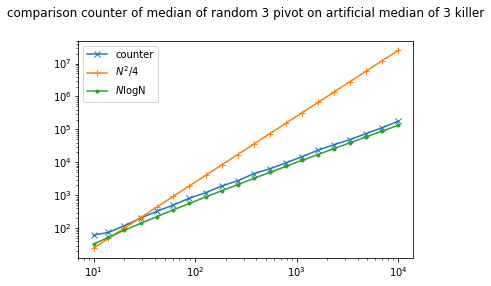

In [24]:
szs = np.logspace(1, 4, 20, dtype=np.int64)
counters = []
for sz in szs:
    m = artificial_killer(sz)
    array, counter = quicksort_r3(m.copy())
    assert np.allclose(array, np.arange(len(m)))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/4, label=r'$N^2$/4', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of median of random 3 pivot on artificial median of 3 killer', y=1.08)
plt.show()

##### median of random 3 can't defende automatic quicksort killer

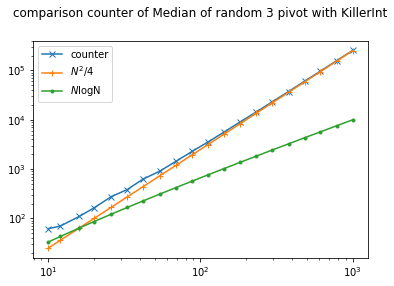

In [25]:
# arrays are smaller to reduce time cost
szs = np.logspace(1, 3, 20, dtype=np.int64)
counters = []
for sz in szs:
    KillerInt.init(sz)
    array, counter = quicksort_r3([KillerInt() for _ in range(sz)])
    array = [f.f for f in array]
    assert np.allclose(array, np.arange(sz))
    counters.append(counter)
ax = plt.gca()
ax.plot(szs, counters, label='counter', marker='x')
ax.plot(szs, szs ** 2/4, label=r'$N^2$/4', marker='+')
ax.plot(szs, szs * np.log2(szs), label=r'$N\rm{log}N$', marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.title('comparison counter of Median of random 3 pivot with KillerInt', y=1.08)
plt.show()